# Predict quality of the connection

**About Data**  
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. This dataset contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment.

**Goal**   
Build a network intrusion detector, a predictive model capable of distinguishing between bad connections, called intrusions or attacks, and good normal connections. 

1. [Get Data](#getdata)
2. [Data Cleaning](#clean)
3. [Train - Test Split](#split)
4. [Build Parallel XGBoost Classifier](#model)
5. [Evaluate Execuation Speed vs Number of Threads](#eval)
6. [Switch Environment to Default Anaconda S](#switchenv)
7. [Predict](#predict1)
7. [Deploy model](#deploy) 
8. [Load Model](#load)
9. [Make Predictions](#predict2)

In [42]:
#Import required libraries
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import time
from matplotlib import pyplot
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<a id='getdata'></a>
# Get Data

In [43]:
# Gat data from UCI data repo 
data=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/kddcup.data.gz',header=None)
data.head()


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [44]:
# Assign column names to the dataframe
columns=[]
for i in range(len(data.columns)):
    columns.append('col'+str(i))
columns[41]='connection_type'    
data.columns=columns

data.shape

(4898431, 42)

<a id='clean'></a>
# Data Cleaning

In [45]:
# Check for missing values
missing=data.isnull().sum()
missing[missing>0]

Series([], dtype: int64)

In [46]:
# Remove '.' from target variable - connection_type
data['connection_type']=data['connection_type'].apply(lambda x: x.replace('.',''))
# Convert target into binary output 0 = bad connection & 1= normal/good connection
data['connection_type']=data['connection_type'].apply(lambda x: 1 if x=='normal' else 0)

In [47]:
# Create dummies from categorical variables
data=pd.get_dummies(data,columns=['col1','col2','col3'])

In [48]:
data.shape

(4898431, 123)

In [51]:
# Downsample data
data=data.sample(1000000)

<a id='split'></a>
## Train - Test Split

In [52]:
from sklearn.model_selection import train_test_split
X = data.drop('connection_type',axis=1)
y = data.loc[:,['connection_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

<a id='model'></a>
## Build Parallel XGBoost Classifier
This is with XS Environment 

In [10]:
#https://machinelearningmastery.com/best-tune-multithreading-support-xgboost-python/

results = []
# Number of threads
num_threads = [1,2,4]

for n in num_threads:
    start = time.time()
    model = XGBClassifier(nthread=n)
    model.fit(X_train, y_train.values.ravel())
    elapsed = time.time() - start
    print(n, elapsed)
    results.append(elapsed)

1 208.50995898246765
2 111.64365196228027
4 118.69369602203369


<a id='eval'></a>
## Evaluate Execuation Speed vs Number of Threads

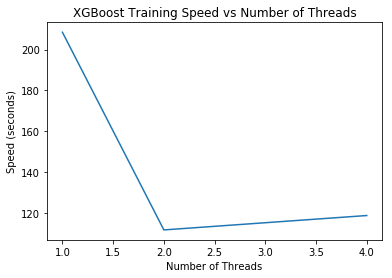

In [11]:
# plot results
pyplot.plot(num_threads, results)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

<a id='switchenv'></a>
## Switch Environment to Default Anaconda S

In [53]:
results = []
# Number of threads
num_threads = [1,2,4]

for n in num_threads:
    start = time.time()
    model = XGBClassifier(nthread=n)
    model.fit(X_train, y_train.values.ravel())
    elapsed = time.time() - start
    print(n, elapsed)
    results.append(elapsed)



1 206.95058274269104
2 107.88305020332336
4 59.95731067657471


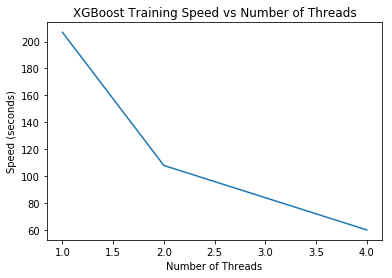

In [54]:
# plot results
pyplot.plot(num_threads, results)
pyplot.ylabel('Speed (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

<a id='predict1'></a>
## Predict

In [56]:
predictions=model.predict(X_test)

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)

0.99976666666666669

<a id='deploy'></a>
## Deploy model

In [29]:
# Install watson_machine_learning_client library  
!pip install watson_machine_learning_client

    100% |████████████████████████████████| 450kB 2.0MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 9.2MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 8.9MB/s eta 0:00:01
  Running setup.py bdist_wheel for tabulate ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/7c/fc/c4/f89c90e8bb6a0052a4ad4a9bc30a61429fea5d3439c63e2efd
Successfully built tabulate


In [58]:
#import libraray and insert credentials

from watson_machine_learning_client  import WatsonMachineLearningAPIClient
wml_credentials ={
  "url": "https://ibm-watson-ml.mybluemix.net",
  "access_key": "*******************************",
  "username": "*******************************",
  "password": "*******************************",
  "instance_id": "*******************************"
}

In [59]:
# Create API client by running below code.
client = WatsonMachineLearningAPIClient(wml_credentials)

In [60]:
#Define model name
model_props = {client.repository.ModelMetaNames.NAME: "XGB Model"}

In [61]:
# Publish model in Watson Machine Learning repository on Cloud
published_model = client.repository.store_model(model=model,meta_props=model_props,training_data=X_train,training_target=y_train.values)

<a id='load'></a>
## Load Model

In [62]:
# Get model details 
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

In [63]:
# load saved model from specified instance of Watson Machine Learning.
loaded_model = client.repository.load(published_model_uid)

<a id='predict2'></a>
## Make Predictions

In [64]:
# make predictions on test data set
test_predictions = loaded_model.predict(X_test)

In [65]:
print(test_predictions)

[0 0 0 ..., 0 0 0]
